## Import modules/scripts and optimize portfolio weights:

In [2]:
import torch
import json
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import date, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from cov_matrix import MPTCovMat
from allocator import WeightOptimizer
from backtesting import BackTester

### Set desired parameters

In [ ]:
# ---------- OPTIMIZATION ----------
train_start = date(2017,1,1)
train_end = date(2018,12,31)

#loss function:
calmar_co = 0.3 #calmar
omega_co = 0.1 #omega
sortino_co = 0.6 #sortino

#target:
rf = 0.025 #risk free rate (can be used as target rate instead)
rf_period = timedelta(365) #number of days for risk free, e.g. 365 for annual 

num_iter = 10000 #number of weight update iterations
weight_decay = 0.1 #affects distribution of weights - higher value will lead to more even distribution

# ---------- COMPARISON ---------- 
test_start=date(2019,1,1)
test_end=date(2019,12,31 )
comparison_ticker = '^OMX' #ticker of index to compare against


NameError: name 'date' is not defined

### Optimize weights

In [3]:
with open("assets.json") as assets_file:
    ticker_list = json.load(assets_file)

tickers = yf.Tickers(ticker_list)

#get data
data = MPTCovMat(tickers=tickers,start=train_start,end=train_end)
returns = data.log_return_df
col_indices = data.col_indices
asset_names = [col_indices[i] for i in sorted(col_indices.keys())]

allocator = WeightOptimizer(lr=1e-3,num_assets=len(asset_names),risk_free=rf,risk_free_period=rf_period,num_iter=num_iter, weight_decay=weight_decay)
weights_np = allocator.optimize_weights(returns=torch.tensor(returns.values),alpha=calmar_co,beta=omega_co,gamma=sortino_co, )
cos_losses, pf_daily_returns = allocator.cos_losses_tensor,allocator.pf_daily_returns
weights = pd.DataFrame(weights_np, index=asset_names, columns=['Weights'])
weights.index.name = 'Ticker'
weights['Weights %'] = weights['Weights']*100
weights['Weights %'].to_csv('weights.csv')
print(weights['Weights %'])

NameError: name 'train_start' is not defined

### Plot sharpe ratios to number of iterations

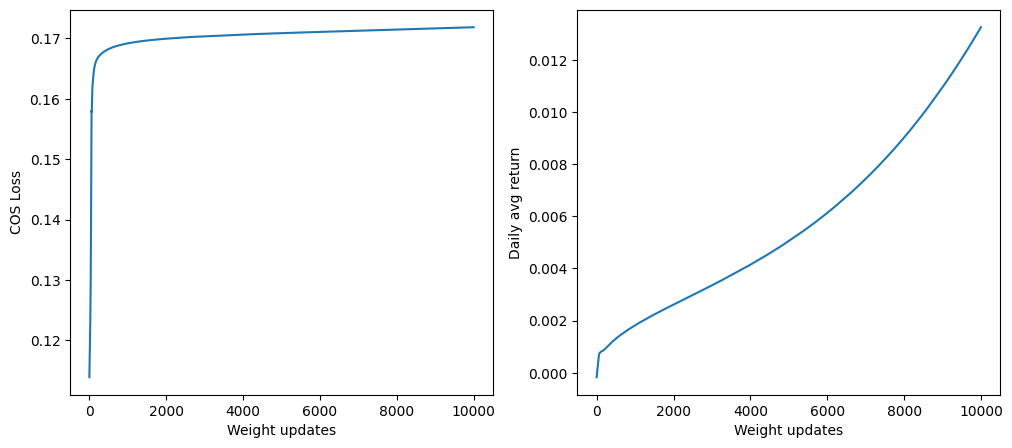

In [ ]:
x_df = pd.DataFrame(range(0,num_iter))
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
ax1.plot(x_df,cos_losses.numpy(force=True),)
ax1.set_xlabel('Weight updates')
ax1.set_ylabel('COS Loss')
ax2.plot(x_df,pf_daily_returns.numpy(force=True),)
ax2.set_xlabel('Weight updates')
ax2.set_ylabel('Daily avg return')
plt.show()

## Backtesting

### Get comparison data

In [ ]:
tester = BackTester(test_weights=pd.DataFrame(weights['Weights']),start=test_start,end=test_end,tickers=tickers)
comp_data = yf.Ticker(comparison_ticker).history(start=test_start,end=test_end,auto_adjust=True)
comp_returns:pd.DataFrame = comp_data['Close'].pct_change(1)
comp_returns.dropna(inplace=True)
comp_cumulative = np.exp(comp_returns.cumsum()) - 1

[*********************100%***********************]  30 of 30 completed


TESTING


### Plot  results

Comparison portfolio return: 27.31 %
Optimized portfolio return: 43.03 %
Comparison portfolio sharpe: 0.10918245531798641
Optimized portfolio sharpe: Weights    0.160842
dtype: float64
Percentage point difference: 15.72 pp
Percentage difference: 57.56 %


/Users/daniel/Desktop/Sidoprojekt/PortOpt/portopt-venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


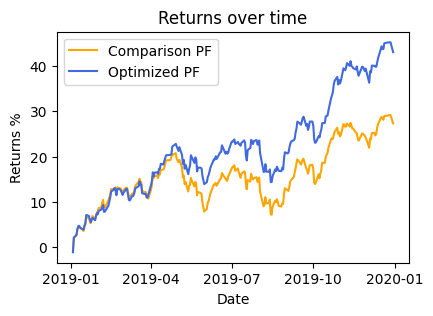

In [ ]:
comp_cumulative = pd.DataFrame(comp_cumulative)
test_returns = tester.test_portfolio_returns
test_cumulative = tester.cumulative_returns(test_returns)
ax1=plt.subplot(1,2,1)
ax1.set_title('Returns over time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Returns %')
ax1.figure.set_size_inches(10,3)
ax1.xaxis.set_major_formatter(mdates.AutoDateFormatter('%Y'))
ax1.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=2,maxticks=6))
ax1.plot(comp_cumulative.mul(100),color='orange')
ax1.plot(test_cumulative.mul(100),color='royalblue')
ax1.legend(['Comparison PF','Optimized PF'])
comp_final_return = round((comp_cumulative.iloc[-1].values*100).item(),2)
optimized_final_return = round((test_cumulative.iloc[-1,:].values*100).item(),2)
comp_optim_diff = optimized_final_return-comp_final_return
perc_diff = round(((optimized_final_return/comp_final_return)-1)*100,2)

daily_rf = (1 + rf) ** (1 / rf_period.days) - 1
daily_rf = 0

sharpe_comp = (np.mean(comp_returns)-daily_rf)/np.std(comp_returns)-daily_rf
sharpe_opt = (np.mean(test_returns)-daily_rf)/np.std(test_returns)-daily_rf

print(f'Comparison portfolio return: {str(comp_final_return)+' %'}')
print(f'Optimized portfolio return: {str(optimized_final_return)+' %'}')
print(f'Comparison portfolio sharpe: {str(sharpe_comp)}')
print(f'Optimized portfolio sharpe: {str(sharpe_opt)}')
print(f'Percentage point difference: {round(comp_optim_diff,2)} pp')
print(f'Percentage difference: {round(((optimized_final_return/comp_final_return)-1)*100,2)} %')